In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [124]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [125]:
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False 
######## 读取数据 ########
sheet = pd.read_excel('data_input/美国10债Trend2.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet.set_index('Date', inplace=True) 
sheet = sheet.reset_index().rename(columns={'index': 'Date'})

In [126]:
sheet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8509 entries, 0 to 8508
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        8509 non-null   datetime64[ns]
 1   10年期美国国债收益率                 8509 non-null   float64       
 2   10年期美国国债收益率Trend/F0.05      8509 non-null   float64       
 3   10年期美国国债收益率Non-Trend/F0.05  8509 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 266.0 KB


In [127]:
sheet.tail()

,Date,10年期美国国债收益率,10年期美国国债收益率Trend/F0.05,10年期美国国债收益率Non-Trend/F0.05
8504,2025-10-27,4.01,4.259687,-0.2497
8505,2025-10-28,3.99,4.259218,-0.2692
8506,2025-10-29,4.08,4.258745,-0.1787
8507,2025-10-30,4.11,4.258268,-0.1483
8508,2025-10-31,4.11,4.257788,-0.1478


In [128]:
sheet =  sheet[['Date','10年期美国国债收益率Trend/F0.05','10年期美国国债收益率']]
# 对两列进行线性插值填充空缺值
sheet['10年期美国国债收益率Trend/F0.05'] = sheet['10年期美国国债收益率Trend/F0.05'].interpolate(method='linear')
sheet['10年期美国国债收益率'] = sheet['10年期美国国债收益率'].interpolate(method='linear')

sheet = sheet.dropna()

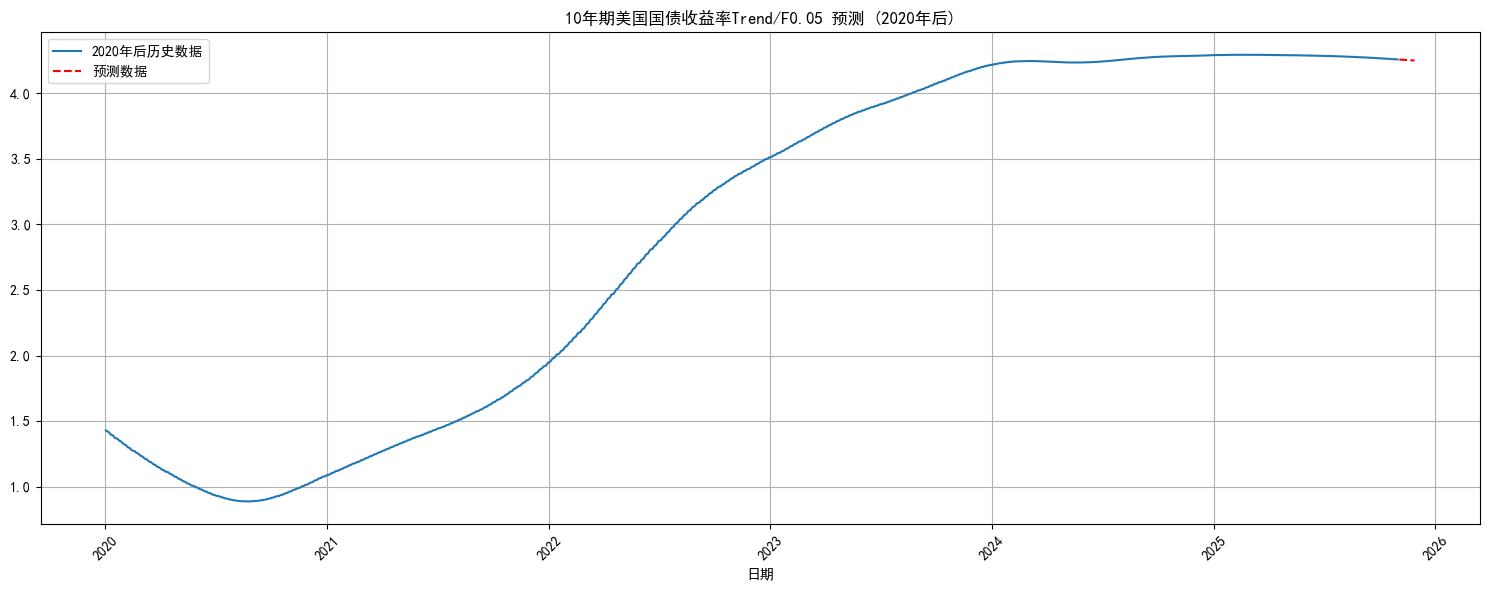

In [129]:

# 获取最后一个日期
last_date = pd.to_datetime(sheet['Date'].iloc[-1])

# 生成未来20个工作日
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')  # 生成30天以确保获得20个工作日
future_dates = future_dates[future_dates.dayofweek < 5][:20]  # 只保留工作日并取前20天

# 获取最后30个历史值用于线性回归
last_values = sheet['10年期美国国债收益率Trend/F0.05'].tail(30).values
x = np.arange(len(last_values))
y = last_values

# 进行线性回归
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

# 预测未来20个值
future_x = np.arange(len(last_values), len(last_values) + 20)
future_values = p(future_x)

# 创建预测数据框
future_df = pd.DataFrame({
    'Date': future_dates,
    '10年期美国国债收益率Trend/F0.05': future_values
})

# 合并历史数据和预测数据
sheet_with_predictions = pd.concat([sheet, future_df], ignore_index=True)
# 筛选2020年之后的数据
sheet_2020 = sheet[sheet['Date'] >= '2020-01-01']

# 绘制结果
plt.figure(figsize=(15, 6))
plt.plot(sheet_2020['Date'], sheet_2020['10年期美国国债收益率Trend/F0.05'], label='2020年后历史数据')
plt.plot(future_df['Date'], future_df['10年期美国国债收益率Trend/F0.05'], 'r--', label='预测数据')
plt.title('10年期美国国债收益率Trend/F0.05 预测 (2020年后)')
plt.xlabel('日期')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [130]:
########################   读取数据  #########################################
sheet_non_trend = pd.read_excel('eta/10年期美国国债收益率Non-Trend-F0.05_合并数据.xlsx', sheet_name='Sheet1')
sheet_non_trend['Date'] = pd.to_datetime(sheet_non_trend['Date'])
# trend + non-trend 
merged_df = pd.merge(
    sheet_non_trend[['Date', '预测值']], 
    future_df[['Date', '10年期美国国债收益率Trend/F0.05']], 
    on='Date',
    how='outer'
)


In [131]:
sheet_non_trend

,Date,真实值,预测值
0,2025-12-01,NaN,-0.1331
1,2025-11-28,NaN,-0.1584
2,2025-11-27,NaN,-0.1674
3,2025-11-26,NaN,-0.1102
4,2025-11-25,NaN,-0.0934
...,...,...,...
746,2023-01-09,0.0012,NaN
747,2023-01-06,0.0249,NaN
748,2023-01-05,0.1885,NaN
749,2023-01-04,0.1722,NaN


In [132]:
merged_df = merged_df
merged_df

,Date,预测值,10年期美国国债收益率Trend/F0.05
0,2023-01-03,NaN,NaN
1,2023-01-04,NaN,NaN
2,2023-01-05,NaN,NaN
3,2023-01-06,NaN,NaN
4,2023-01-09,NaN,NaN
...,...,...,...
746,2025-11-25,-0.0934,4.250800
747,2025-11-26,-0.1102,4.250373
748,2025-11-27,-0.1674,4.249947
749,2025-11-28,-0.1584,4.249520


In [133]:
# 删除包含空值的行

# 计算最终的
merged_df['10年期美国国债收益率'] = merged_df['预测值'] + merged_df['10年期美国国债收益率Trend/F0.05']
merged_df.tail()

,Date,预测值,10年期美国国债收益率Trend/F0.05,10年期美国国债收益率
746,2025-11-25,-0.0934,4.250800,4.157400
747,2025-11-26,-0.1102,4.250373,4.140173
748,2025-11-27,-0.1674,4.249947,4.082547
749,2025-11-28,-0.1584,4.249520,4.091120
750,2025-12-01,-0.1331,NaN,NaN


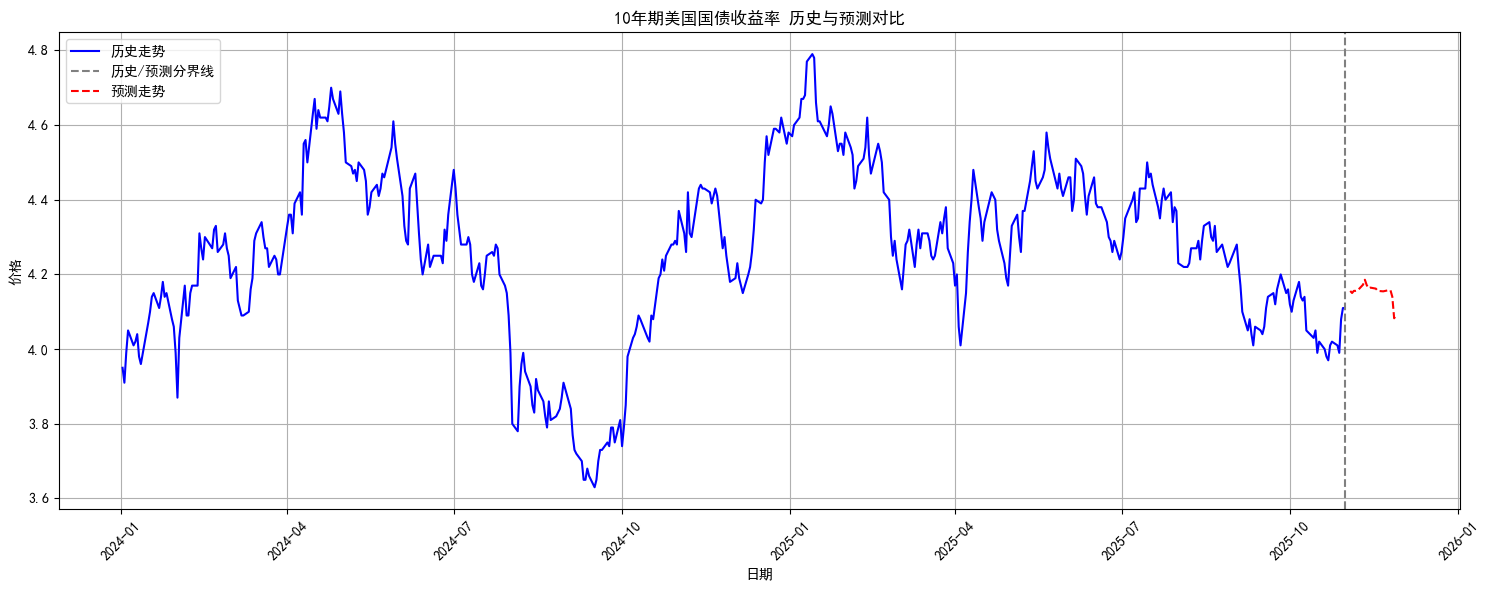

In [134]:
# 绘制最终走势图
plt.figure(figsize=(15, 6))
# 筛选2020年之后的数据
sheet_2020 = sheet[sheet['Date'] >= '2024-01-01']
# 绘制历史数据
plt.plot(sheet_2020['Date'], sheet_2020['10年期美国国债收益率'], label='历史走势', color='blue')
# 添加垂直分隔线,标记历史数据和预测数据的分界点
last_historical_date = sheet_2020['Date'].iloc[-1]
plt.axvline(x=last_historical_date, color='gray', linestyle='--', label='历史/预测分界线')
# 绘制预测数据
plt.plot(merged_df['Date'], merged_df['10年期美国国债收益率'], label='预测走势', color='red', linestyle='--')

plt.title('10年期美国国债收益率 历史与预测对比')
plt.xlabel('日期')
plt.ylabel('价格')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [135]:
sheet_data_2023_shizhi = sheet[sheet['Date'].dt.year >= 2023][['Date', '10年期美国国债收益率']]
sheet_data_2023_shizhi.columns = ['Date', '实际值']
future_df_shizhi = merged_df[['Date', '10年期美国国债收益率']]
merged_df_shizhi = pd.merge(sheet_data_2023_shizhi, future_df_shizhi, on='Date', how='outer')
merged_df_shizhi = merged_df_shizhi.sort_values('Date', ascending=False)
merged_df_shizhi['Date'] = merged_df_shizhi['Date'].dt.strftime('%Y/%m/%d')
merged_df_shizhi.to_excel('eta/10年期美国国债收益率_合并数据.xlsx', index=False,float_format='%.2f')
merged_df_shizhi

,Date,实际值,10年期美国国债收益率
750,2025/12/01,NaN,NaN
749,2025/11/28,NaN,4.091120
748,2025/11/27,NaN,4.082547
747,2025/11/26,NaN,4.140173
746,2025/11/25,NaN,4.157400
...,...,...,...
4,2023/01/09,3.53,NaN
3,2023/01/06,3.55,NaN
2,2023/01/05,3.71,NaN
1,2023/01/04,3.69,NaN


In [136]:
# 将日期列转换为datetime格式
merged_df_shizhi['Date'] = pd.to_datetime(merged_df_shizhi['Date'])
# 按月份重采样并取每月最后一个交易日的数据
monthly_df_shizhi = merged_df_shizhi.set_index('Date').resample('ME').last()
monthly_df_shizhi = monthly_df_shizhi.sort_values('Date', ascending=False)
# 重置索引并格式化日期
monthly_df_shizhi = monthly_df_shizhi.reset_index()
monthly_df_shizhi['Date'] = monthly_df_shizhi['Date'].dt.strftime('%Y/%m/%d')
monthly_df_shizhi = monthly_df_shizhi.dropna(subset=['实际值', '10年期美国国债收益率'], how='all')
# 保存月度数据到Excel
monthly_df_shizhi.to_excel('eta/10年期美国国债收益率_月度数据.xlsx', index=False, float_format='%.2f')
monthly_df_shizhi.head()

,Date,实际值,10年期美国国债收益率
1,2025/11/30,NaN,4.09112
2,2025/10/31,4.11,NaN
3,2025/09/30,4.16,NaN
4,2025/08/31,4.23,NaN
5,2025/07/31,4.37,NaN


---

In [137]:
sheet_data_2023 = sheet[sheet['Date'].dt.year >= 2023][['Date', '10年期美国国债收益率Trend/F0.05']]
sheet_data_2023.columns = ['Date', '实际值']
merged_df_trend = pd.merge(sheet_data_2023, future_df, on='Date', how='outer')
merged_df_trend = merged_df_trend.sort_values('Date', ascending=False)
merged_df_trend['Date'] = merged_df_trend['Date'].dt.strftime('%Y/%m/%d')
merged_df_trend.to_excel('eta/10年期美国国债收益率Trend—F0.05_合并数据.xlsx', index=False,float_format='%.2f')
merged_df_trend

,Date,实际值,10年期美国国债收益率Trend/F0.05
728,2025/11/28,NaN,4.249520
727,2025/11/27,NaN,4.249947
726,2025/11/26,NaN,4.250373
725,2025/11/25,NaN,4.250800
724,2025/11/24,NaN,4.251226
...,...,...,...
4,2023/01/09,3.528773,NaN
3,2023/01/06,3.525130,NaN
2,2023/01/05,3.521486,NaN
1,2023/01/04,3.517842,NaN


In [138]:
# 将日期列转换为datetime格式
merged_df_trend['Date'] = pd.to_datetime(merged_df_trend['Date'])
# 按月份重采样并取每月最后一个交易日的数据
monthly_df_trend = merged_df_trend.set_index('Date').resample('ME').last()
monthly_df_trend = monthly_df_trend.sort_values('Date', ascending=False)
# 重置索引并格式化日期
monthly_df_trend = monthly_df_trend.reset_index()
monthly_df_trend['Date'] = monthly_df_trend['Date'].dt.strftime('%Y/%m/%d')
# 保存月度数据到Excel
monthly_df_trend.to_excel('eta/10年期美国国债收益率Trend—F0.05_月度数据.xlsx', index=False, float_format='%.2f')
monthly_df_trend.head()

,Date,实际值,10年期美国国债收益率Trend/F0.05
0,2025/11/30,NaN,4.24952
1,2025/10/31,4.257788,NaN
2,2025/09/30,4.267470,NaN
3,2025/08/31,4.274952,NaN
4,2025/07/31,4.280818,NaN


---

In [139]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.宏观经济_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "10年期美国国债收益率Trend/F0.05_2.0"

# 调用函数更新数据
success = update_excel_data(merged_df_trend, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [140]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.宏观经济_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "10年期美国国债收益率_2.0"

# 调用函数更新数据
success = update_excel_data(merged_df_shizhi, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [141]:
from Lcel import update_excel_data
file_path = "eta/1.宏观经济_数据上传.xlsx"
sheet_name = "详情页"
identifier = "10年期美国国债收益率Trend/F0.05_2.0"
# 调用函数更新数据
success = update_excel_data(monthly_df_trend, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

数据过滤完成: 保留 23 条数据（2024/01/31 之后），按时间倒序排列
已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/11/30, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件


In [142]:
from Lcel import update_excel_data
file_path = "eta/1.宏观经济_数据上传.xlsx"
sheet_name = "详情页"
identifier = "10年期美国国债收益率_2.0"
# 调用函数更新数据
success = update_excel_data(monthly_df_shizhi, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

数据过滤完成: 保留 23 条数据（2024/01/31 之后），按时间倒序排列
已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/11/30, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
